In [1]:
import pandas as pd
import csv
import gensim.corpora as corpora
import numpy as np
from sklearn.manifold import TSNE
from bokeh import *
from bokeh.models import ColumnDataSource
import matplotlib.pyplot as plt

import pandas as pd
import re
import numpy as np
import re
import nltk
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from gensim.models import LsiModel

import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
import csv

# LSA 돌리기

In [42]:
df = pd.read_csv("D:\\2020-2\\소프트웨어융합캡스톤디자인\\new_jupyter\\data2\\origin\\adhd_origin.csv")

In [2]:
data_ready = []
f = open("D:\\2020-2\\소프트웨어융합캡스톤디자인\\new_jupyter\\data2\\adhd_prepeocess_worddata.csv","rt", encoding = 'utf-8')
reader = csv.reader(f)
for row in reader :
    data_ready.append(row)
    
content_df = pd.DataFrame({'content': data_ready})

In [3]:
#역 토큰화
detokenized_doc = []
for i in range(len(content_df)):
    t = ' '.join(content_df['content'].iloc[i])
    detokenized_doc.append(t)

    
content_df['content'] = detokenized_doc

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer 
 
# settings that you use for count vectorizer will go here 
tfidf_vectorizer=TfidfVectorizer(use_idf=True) 
 
# just send in all your docs here 
tfidf_vectorizer_vectors=tfidf_vectorizer.fit_transform(content_df['content'])

## 토픽 갯수 정하기

In [7]:
def prepare_corpus(doc_clean):
    """
    Input  : clean document
    Purpose: create term dictionary of our courpus and Converting list of documents (corpus) into Document Term Matrix
    Output : term dictionary and Document Term Matrix
    """
    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LDA model
    return dictionary, doc_term_matrix

In [8]:
def create_gensim_lsa_model(doc_clean,number_of_topics,words):
    """
    Input  : clean document, number of topics and number of words associated with each topic
    Purpose: create LSA model using gensim
    Output : return LSA model
    """
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    # generate LSA model
    lsamodel = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
    print(lsamodel.print_topics(num_topics=number_of_topics, num_words=words))
    return lsamodelb

In [11]:
def compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3):
    """
    Input   : dictionary : Gensim dictionary
              corpus : Gensim corpus
              texts : List of input texts
              stop : Max num of topics
    purpose : Compute c_v coherence for various number of topics
    Output  : model_list : List of LSA topic models
              coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        # generate LSA model
        model = LsiModel(doc_term_matrix, num_topics=num_topics, id2word = dictionary)  # train model
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='u_mass')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [10]:
def plot_graph(doc_clean,start, stop, step):
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    model_list, coherence_values = compute_coherence_values(dictionary, doc_term_matrix,doc_clean,
                                                            stop, start, step)
    # Show graph
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

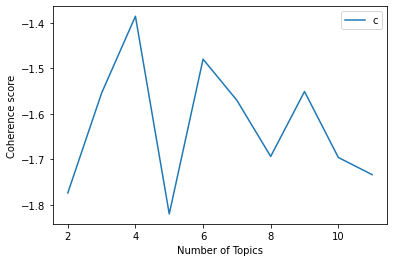

In [13]:
start,stop,step=2,12,1
plot_graph(data_ready,start,stop,step)

# 최종 토픽

In [14]:
# 토픽 주제 10개
from sklearn.decomposition import TruncatedSVD
svd_model = TruncatedSVD(n_components=4, algorithm='randomized', n_iter=100, random_state=122)
lsa = svd_model.fit_transform(X)

In [15]:
terms = vectorizer.get_feature_names() # 단어 집합. 1,000개의 단어가 저장됨.

def get_topics(components, feature_names, n=10):
    for idx, topic in enumerate(components):
        print("Topic %d:" % (idx+1), [(feature_names[i], topic[i].round(5)) for i in topic.argsort()[:-n - 1:-1]])
get_topics(svd_model.components_,terms)

Topic 1: [('feel', 0.22319), ('get', 0.18802), ('take', 0.17905), ('work', 0.16769), ('time', 0.16363), ('thing', 0.1593), ('day', 0.15794), ('know', 0.14219), ('make', 0.14086), ('want', 0.12768)]
Topic 2: [('take', 0.46756), ('med', 0.32297), ('day', 0.26357), ('vyvanse', 0.2151), ('sleep', 0.16992), ('dose', 0.16321), ('medication', 0.15829), ('hour', 0.14238), ('work', 0.10471), ('week', 0.10292)]
Topic 3: [('plan', 0.3081), ('day', 0.29748), ('thing', 0.22144), ('today', 0.19186), ('time', 0.18519), ('week', 0.17538), ('weekend', 0.15973), ('win', 0.15461), ('get', 0.13134), ('list', 0.1276)]
Topic 4: [('today', 0.23513), ('doctor', 0.22989), ('tell', 0.20905), ('appointment', 0.19376), ('last', 0.16541), ('matter', 0.16272), ('back', 0.15729), ('realistically', 0.11828), ('budget_pay', 0.11803), ('medication', 0.11725)]


# 해당 토픽에만 등장하는 단어들의 weight

In [72]:
terms = vectorizer.get_feature_names() # 단어 집합. 1,000개의 단어가 저장됨.

def get_topics(components, feature_names, n=1000):
    for idx, topic in enumerate(components):
        print("Topic %d:" % (idx+1), [(feature_names[i]) for i in topic.argsort()[:-n - 1:-1]])
        print("\n\n")
get_topics(svd_model.components_,terms)

Topic 1: ['feel', 'get', 'take', 'work', 'time', 'thing', 'day', 'know', 'make', 'want', 'go', 'really', 'think', 'try', 'start', 'med', 'even', 'people', 'help', 'say', 'would', 'medication', 'much', 'need', 'week', 'well', 'life', 'tell', 'year', 'good', 'could', 'still', 'also', 'hour', 'find', 'see', 'bad', 'today', 'always', 'first', 'hard', 'focus', 'month', 'way', 'never', 'last', 'keep', 'lot', 'sleep', 'back', 'job', 'give', 'long', 'talk', 'else', 'come', 'school', 'doctor', 'use', 'experience', 'right', 'actually', 'seem', 'anxiety', 'diagnose', 'look', 'vyvanse', 'friend', 'ask', 'read', 'able', 'problem', 'stop', 'forget', 'brain', 'may', 'struggle', 'class', 'new', 'end', 'put', 'happen', 'study', 'sometimes', 'thought', 'remember', 'sure', 'dose', 'stuff', 'guy', 'maybe', 'little', 'write', 'plan', 'enough', 'change', 'many', 'ever', 'task', 'eat', 'symptom', 'issue', 'lose', 'ago', 'pretty', 'normal', 'finally', 'understand', 'appointment', 'different', 'morning', 'mind

In [65]:
# 100개
topic_1= ['feel', 'get', 'take', 'work', 'time', 'thing', 'day', 'know', 'make', 'want', 'go', 'really', 'think', 'try', 'start', 'med', 'even', 'people', 'help', 'say', 'would', 'medication', 'much', 'need', 'week', 'well', 'life', 'tell', 'year', 'good', 'could', 'still', 'also', 'hour', 'find', 'see', 'bad', 'today', 'always', 'first', 'hard', 'focus', 'month', 'way', 'never', 'last', 'keep', 'lot', 'sleep', 'back', 'job', 'give', 'long', 'talk', 'else', 'come', 'school', 'doctor', 'use', 'experience', 'right', 'actually', 'seem', 'anxiety', 'diagnose', 'look', 'vyvanse', 'friend', 'ask', 'read', 'able', 'problem', 'stop', 'forget', 'brain', 'may', 'struggle', 'class', 'new', 'end', 'put', 'happen', 'study', 'sometimes', 'thought', 'remember', 'sure', 'dose', 'stuff', 'guy', 'maybe', 'little', 'write', 'plan', 'enough', 'change', 'many', 'ever', 'task', 'eat']
topic_2 = ['take', 'med', 'day', 'vyvanse', 'sleep', 'dose', 'medication', 'hour', 'work', 'week', 'morning', 'start', 'effect', 'pill', 'doctor', 'eat', 'today', 'first', 'stimulant', 'side_effect', 'night', 'prescribe', 'dosage', 'last', 'experience', 'month', 'wake', 'increase', 'wear', 'switch', 'notice', 'feel', 'afternoon', 'crash', 'pm', 'long', 'prescription', 'drink', 'medicine', 'coffee', 'tired', 'kick', 'concerta', 'weekend', 'bed', 'adderall', 'difference', 'twice', 'methylphenidate', 'ritalin', 'tolerance', 'effective', 'anxiety', 'low', 'ago', 'drug', 'break', 'early', 'yesterday', 'half', 'less', 'evening', 'caffeine', 'normal', 'nap', 'water', 'sleepy', 'focus', 'currently', 'body', 'breakfast', 'tomorrow', 'awake', 'high', 'appetite', 'dexedrine', 'doc', 'usually', 'productive', 'next', 'late', 'pharmacy', 'still', 'psychiatrist', 'daily', 'withdrawal', 'lunch', 'schedule', 'headache', 'plan', 'anxious', 'usual', 'script', 'meal', 'tablet', 'refill', 'couple', 'calm', 'generic', 'hungry']
topic_3 =  ['plan', 'day', 'thing', 'today', 'time', 'week', 'weekend', 'win', 'get', 'list', 'kick', 'celebrate', 'good', 'matter', 'write', 'come', 'today_come_brag', 'easiest', 'reward', 'task', 'prioritize', 'meal', 'keep', 'last', 'trying', 'ready', 'eat', 'identify', 'letter', 'back', 'realistically', 'simple', 'budget_pay', 'leave', 'exle', 'productive', 'wrap', 'bill', 'together', 'check', 'short', 'deny', 'stuff', 'medicine', 'sunday', 'power_myth_exle', 'victory', 'habit', 'binge_drinking', 'successful', 'ecstatic', 'least', 'myth', 'tell', 'make', 'final', 'looking', 'child', 'bottom', 'rarely', 'challenge', 'remember', 'awesome', 'past', 'let', 'big', 'study', 'single', 'later', 'appointment', 'positive', 'far', 'like', 'advice', 'sorry', 'work', 'forget', 'hour', 'hope', 'probably', 'mean', 'moment', 'minute', 'less', 'clean', 'bed', 'even', 'finish', 'phone', 'spend', 'long', 'start', 'wake', 'home', 'late', 'schedule', 'project', 'routine', 'go', 'sleep']
topic_4 = ['today', 'doctor', 'tell', 'appointment', 'last', 'matter', 'back', 'realistically', 'budget_pay', 'medication', 'go', 'deny', 'wrap', 'bill', 'check', 'say', 'successful', 'give', 'hope', 'habit', 'long', 'let', 'year', 'past', 'like', 'far', 'probably', 'could', 'psychiatrist', 'big', 'diagnosis', 'test', 'mean', 'month', 'productive', 'ask', 'want', 'diagnose', 'less', 'would', 'prescription', 'still', 'call', 'insurance', 'med', 'finally', 'bad', 'wait', 'prescribe', 'school', 'get', 'time', 'see', 'weekend', 'help', 'take', 'symptom', 'parent', 'first', 'new', 'treatment', 'psychologist', 'question', 'pharmacy', 'pay', 'mom', 'plan', 'college', 'drug', 'therapist', 'psych', 'adult', 'assessment', 'look', 'treat', 'fill', 'old', 'send', 'referral', 'tomorrow', 'believe', 'teacher', 'depression', 'thank', 'class', 'nervous', 'ago', 'testing', 'therapy', 'office', 'script', 'grade', 'expect', 'specialist', 'refer', 'visit', 'dosage', 'refill', 'fail', 'may']

In [75]:
topic_1= ['feel', 'get', 'take', 'work', 'time', 'thing', 'day', 'know', 'make', 'want', 'go', 'really', 'think', 'try', 'start', 'med', 'even', 'people', 'help', 'say', 'would', 'medication', 'much', 'need', 'week', 'well', 'life', 'tell', 'year', 'good', 'could', 'still', 'also', 'hour', 'find', 'see', 'bad', 'today', 'always', 'first', 'hard', 'focus', 'month', 'way', 'never', 'last', 'keep', 'lot', 'sleep', 'back', 'job', 'give', 'long', 'talk', 'else', 'come', 'school', 'doctor', 'use', 'experience', 'right', 'actually', 'seem', 'anxiety', 'diagnose', 'look', 'vyvanse', 'friend', 'ask', 'read', 'able', 'problem', 'stop', 'forget', 'brain', 'may', 'struggle', 'class', 'new', 'end', 'put', 'happen', 'study', 'sometimes', 'thought', 'remember', 'sure', 'dose', 'stuff', 'guy', 'maybe', 'little', 'write', 'plan', 'enough', 'change', 'many', 'ever', 'task', 'eat', 'symptom', 'issue', 'lose', 'ago', 'pretty', 'normal', 'finally', 'understand', 'appointment', 'different', 'morning', 'mind', 'leave', 'minute', 'notice', 'night', 'person', 'point', 'love', 'hate', 'let', 'advice', 'high', 'depression', 'mean', 'question', 'diagnosis', 'less', 'next', 'idea', 'test', 'home', 'ill', 'bit', 'call', 'deal', 'learn', 'thank', 'wonder', 'post', 'fuck', 'almost', 'realize', 'sit', 'great', 'add', 'psychiatrist', 'probably', 'head', 'already', 'tired', 'hope', 'college', 'finish', 'live', 'break', 'kind', 'late', 'hear', 'part', 'effect', 'big', 'usually', 'shit', 'spend', 'parent', 'recently', 'list', 'reason', 'later', 'wait', 'move', 'become', 'stay', 'whole', 'cause', 'due', 'wrong', 'away', 'turn', 'place', 'far', 'feeling', 'stimulant', 'phone', 'least', 'instead', 'often', 'matter', 'manage', 'explain', 'tip', 'bed', 'old', 'happy', 'decide', 'literally', 'wake', 'weekend', 'care', 'easy', 'guess', 'early', 'fail', 'completely', 'past', 'anymore', 'motivation', 'second', 'family', 'suppose', 'anxious', 'couple', 'super', 'kid', 'prescribe', 'constantly', 'run', 'book', 'moment', 'stress', 'half', 'clean', 'pill', 'check', 'basically', 'switch', 'however', 'tomorrow', 'control', 'figure', 'word', 'wear', 'productive', 'relate', 'watch', 'play', 'side_effect', 'mom', 'believe', 'grade', 'room', 'weird', 'currently', 'course', 'small', 'like', 'bring', 'sense', 'distract', 'together', 'show', 'drive', 'especially', 'schedule', 'low', 'energy', 'yesterday', 'adult', 'dosage', 'set', 'stupid', 'medicine', 'relationship', 'conversation', 'habit', 'one', 'drug', 'important', 'soon', 'share', 'adhd', 'affect', 'cry', 'project', 'listen', 'kick', 'trouble', 'walk', 'full', 'difference', 'drink', 'situation', 'miss', 'mess', 'close', 'lazy', 'child', 'pay', 'worry', 'difficult', 'enjoy', 'complete', 'process', 'yet', 'increase', 'similar', 'positive', 'expect', 'real', 'suck', 'calm', 'short', 'alone', 'sound', 'nee', 'exam', 'prescription', 'self', 'quite', 'fact', 'type', 'result', 'possible', 'teacher', 'note', 'story', 'honestly', 'money', 'follow', 'single', 'memory', 'sort', 'function', 'fast', 'body', 'hand', 'therapist', 'fine', 'lack', 'answer', 'medicate', 'homework', 'begin', 'depressed', 'wish', 'pass', 'treatment', 'win', 'treat', 'game', 'pick', 'coffee', 'ready', 'food', 'assignment', 'open', 'entire', 'emotion', 'world', 'waste', 'routine', 'stick', 'definitely', 'extremely', 'anyway', 'car', 'exercise', 'hit', 'mood', 'angry', 'therapy', 'speak', 'rest', 'social', 'sorry', 'disorder', 'semester', 'daily', 'consider', 'improve', 'amount', 'fix', 'house', 'send', 'buy', 'slow', 'around', 'fun', 'simple', 'student', 'level', 'absolutely', 'bored', 'attention', 'rather', 'nice', 'online', 'easily', 'interest', 'step', 'curious', 'barely', 'music', 'sad', 'procrastinate', 'research', 'mention', 'certain', 'hurt', 'handle', 'mistake', 'tend', 'effort', 'paper', 'final', 'thinking', 'exle', 'fall', 'top', 'huge', 'force', 'support', 'hold', 'crazy', 'meet', 'sick', 'case', 'insurance', 'avoid', 'order', 'drop', 'goal', 'crash', 'office', 'track', 'mostly', 'rant', 'state', 'worth', 'twice', 'psych', 'overwhelmed', 'information', 'suddenly', 'though', 'water', 'appreciate', 'interesting', 'age', 'fill', 'frustrated', 'terrible', 'seriously', 'pm', 'push', 'afraid', 'option', 'reddit', 'negative', 'adderall', 'nervous', 'face', 'failure', 'ability', 'date', 'common', 'interested', 'system', 'everyday', 'mental', 'side', 'continue', 'whenever', 'totally', 'free', 'clear', 'lately', 'period', 'emotional', 'concerta', 'lead', 'cope', 'accept', 'successful', 'act', 'helpful', 'extra', 'email', 'scare', 'somehow', 'concentrate', 'fear', 'psychologist', 'realise', 'allow', 'amazing', 'future', 'career', 'strong', 'catch', 'comment', 'grow', 'quickly', 'afternoon', 'lie', 'random', 'general', 'math', 'normally', 'upset', 'page', 'pain', 'obviously', 'eye', 'quit', 'sub', 'require', 'apply', 'group', 'frustrating', 'app', 'video', 'fucking', 'reading', 'effective', 'throw', 'likely', 'personal', 'benefit', 'form', 'meal', 'girl', 'exactly', 'boss', 'organize', 'celebrate', 'university', 'fight', 'scared', 'major', 'degree', 'stand', 'dumb', 'horrible', 'damn', 'several', 'suggest', 'bore', 'eventually', 'deadline', 'boring', 'remind', 'worried', 'straight', 'constant', 'usual', 'summer', 'excited', 'evening', 'choose', 'diagnosed', 'bill', 'dream', 'impossible', 'simply', 'awesome', 'immediately', 'current', 'suggestion', 'pull', 'excuse', 'decision', 'smart', 'healthy', 'doc', 'space', 'describe', 'chance', 'cut', 'build', 'suffer', 'caffeine', 'unable', 'aware', 'challenge', 'ritalin', 'true', 'condition', 'annoying', 'sign', 'quiet', 'term', 'reach', 'mad', 'perfect', 'line', 'graduate', 'severe', 'topic', 'multiple', 'young', 'reward', 'computer', 'die', 'proud', 'heart', 'dad', 'subject', 'area', 'text', 'apparently', 'detail', 'lunch', 'create', 'hopefully', 'relax', 'edit', 'specific', 'boyfriend', 'include', 'busy', 'methylphenidate', 'song', 'awful', 'husband', 'depress', 'fire', 'letter', 'somewhere', 'mother', 'must', 'meeting', 'name', 'weight', 'imagine', 'bother', 'doubt', 'shower', 'properly', 'actual', 'progress', 'stuck', 'annoy', 'practice', 'quick', 'generally', 'number', 'man', 'dopamine', 'nearly', 'tldr', 'concentration', 'physically', 'medical', 'slowly', 'ton', 'recommend', 'deny', 'behavior', 'reminder', 'visit', 'activity', 'skill', 'focused', 'movie', 'working', 'anger', 'success', 'intense', 'distraction', 'physical', 'partner', 'compare', 'fit', 'writing', 'assessment', 'light', 'repeat', 'motivated', 'solution', 'incredibly', 'front', 'shift', 'personality', 'impulsive', 'interview', 'kill', 'assume', 'response', 'middle', 'pharmacy', 'difficulty', 'mentally', 'jump', 'forever', 'lecture', 'rarely', 'base', 'ignore', 'ruin', 'hyperfocus', 'vent', 'truly', 'hobby', 'awake', 'laugh', 'zone', 'procrastination', 'develop', 'wrap', 'alarm', 'blame', 'potential', 'regular', 'shut', 'hell', 'wife', 'deep', 'desk', 'company', 'respond', 'sentence', 'worse', 'useless', 'dish', 'choice', 'fully', 'concern', 'funny', 'accomplish', 'poor', 'motivate', 'seek', 'opinion', 'present', 'none', 'exhaust', 'key', 'antidepressant', 'health', 'loud', 'improvement', 'chore', 'main', 'train', 'sleepy', 'breakfast', 'message', 'basic', 'exhausted', 'cycle', 'possibly', 'hang', 'community', 'agree', 'tonight', 'session', 'brother', 'adhder', 'strategy', 'exist', 'tolerance', 'save', 'hyper', 'program', 'burn', 'identify', 'nap', 'freak', 'article', 'clothe', 'report', 'bunch', 'cover', 'prioritize', 'manager', 'achieve', 'receive', 'trust', 'offer', 'fault', 'country', 'otherwise', 'afford', 'event', 'slightly', 'somewhat', 'overall', 'realistically', 'panic', 'lol', 'cool', 'discuss', 'trying', 'rush', 'patient', 'uni', 'apartment', 'action', 'honest', 'internet', 'abuse', 'teach', 'neurotypical', 'inattentive', 'convince', 'guilty', 'laundry', 'productivity', 'human', 'piece', 'extreme', 'looking', 'aspect', 'overwhelm', 'hyperactive', 'screw', 'serious', 'beat', 'management', 'hungry', 'average', 'reaction', 'dog', 'structure', 'dinner', 'overwhelming', 'girlfriend', 'direction', 'history', 'total', 'environment', 'store', 'search', 'bottom', 'woman', 'stare', 'script', 'sister', 'title', 'mine', 'frustrate', 'min', 'anyways', 'professional', 'specifically', 'frustration', 'cost', 'maintain', 'budget_pay', 'childhood', 'professor', 'forward', 'creative', 'joke', 'badly', 'tear', 'return', 'understanding', 'solve', 'impact', 'touch', 'pressure', 'prepare', 'business', 'comfortable', 'fairly', 'regard', 'unmedicated', 'ahead', 'shitty', 'reduce', 'cold', 'refer', 'testing', 'appetite', 'update', 'count', 'personally', 'unfortunately', 'third', 'noise', 'door', 'rule', 'etc', 'bathroom', 'draw', 'previous', 'refuse', 'trick', 'coworker', 'subreddit', 'yell', 'headache', 'bipolar', 'reply', 'reality', 'clearly', 'skip', 'accommodation', 'block', 'essay', 'pop', 'decent', 'daydream', 'info', 'adjust', 'position', 'obvious', 'wall', 'link', 'dexedrine', 'attempt', 'react', 'consistently', 'confuse', 'voice', 'stressful', 'victory', 'hair', 'genuinely', 'urge', 'method', 'kinda', 'sensitive', 'contact', 'planning', 'differently', 'involve', 'specialist', 'confused', 'confident', 'pattern', 'crap', 'uncomfortable', 'raise', 'proper', 'bottle', 'useful', 'miserable', 'language', 'refill', 'excite', 'speed', 'expensive', 'undiagnose', 'floor', 'ass', 'screen', 'regularly', 'field', 'succeed', 'suspect', 'power', 'art', 'material', 'inability', 'rsd', 'anywhere', 'consistent', 'generic', 'fatigue', 'trigger', 'slip', 'related', 'confidence', 'gym', 'sudden', 'provide', 'obsess', 'empty', 'irritable', 'meditation', 'correct', 'particular', 'accidentally', 'particularly', 'private', 'approach', 'scream', 'complain', 'tire', 'easiest', 'son', 'stimulate', 'trip', 'today_come_brag', 'entirely', 'double', 'holiday', 'safe', 'picture', 'opportunity', 'discover', 'drain', 'odd', 'withdrawal', 'strange', 'background', 'bag', 'hyperfocuse', "overcome", 'box', 'tough', 'knowledge', 'okay', 'learning', 'diet', 'thread']
topic_2 = ['take', 'med', 'day', 'vyvanse', 'sleep', 'dose', 'medication', 'hour', 'work', 'week', 'morning', 'start', 'effect', 'pill', 'doctor', 'eat', 'today', 'first', 'stimulant', 'side_effect', 'night', 'prescribe', 'dosage', 'last', 'experience', 'month', 'wake', 'increase', 'wear', 'switch', 'notice', 'feel', 'afternoon', 'crash', 'pm', 'long', 'prescription', 'drink', 'medicine', 'coffee', 'tired', 'kick', 'concerta', 'weekend', 'bed', 'adderall', 'difference', 'twice', 'methylphenidate', 'ritalin', 'tolerance', 'effective', 'anxiety', 'low', 'ago', 'drug', 'break', 'early', 'yesterday', 'half', 'less', 'evening', 'caffeine', 'normal', 'nap', 'water', 'sleepy', 'focus', 'currently', 'body', 'breakfast', 'tomorrow', 'awake', 'high', 'appetite', 'dexedrine', 'doc', 'usually', 'productive', 'next', 'late', 'pharmacy', 'still', 'psychiatrist', 'daily', 'withdrawal', 'lunch', 'schedule', 'headache', 'plan', 'anxious', 'usual', 'script', 'meal', 'tablet', 'refill', 'couple', 'calm', 'generic', 'hungry', 'insurance', 'effectiveness', 'psych', 'bit', 'curious', 'wonder', 'energy', 'vitamin', 'bottle', 'mood', 'benefit', 'later', 'booster', 'advice', 'noon', 'alarm', 'suppose', 'adjust', 'food', 'antidepressant', 'euphoria', 'however', 'normally', 'exercise', 'appointment', 'fatigue', 'period', 'double', 'fall_asleep', 'insomnia', 'prescribed', 'expect', 'irritable', 'exhausted', 'ready', 'capsule', 'reduce', 'everyday', 'release', 'hetamine', 'shift', 'fine', 'sleeping', 'rest', 'stomach', 'supplement', 'lower', 'worried', 'change', 'trial', 'function', 'short', 'improvement', 'second', 'jittery', 'affect', 'nausea', 'heart', 'nonstimulant', 'focused', 'concentration', 'routine', 'back', 'asleep', 'holiday', 'noticeable', 'today_come_brag', 'easiest', 'decrease', 'nauseous', 'duration', 'depressed', 'intuniv', 'boost', 'medikinet', 'aderall', 'heart_rate', 'comedown', 'guanfacine', 'brand', 'dexhetamine', 'decide', 'productivity', 'midnight', 'well', 'weight', 'tiredness', 'melatonin', 'zombie', 'option', 'regular', 'amount', 'full', 'stim', 'drowsy', 'sideeffect', 'recently', 'abuse', 'switching', 'placebo', 'wait', 'taper', 'skip', 'drinking', 'slightly', 'lethargic', 'mild', 'diet', 'unmedicated', 'dextrohetamine', 'prioritize', 'adderal', 'vacation', 'titrate', 'cold', 'cover', 'vyvance', 'experiment', 'fill', 'similar', 'shower', 'bump', 'pharmacist', 'stay_awake', 'wondering', 'initial', 'clonidine', 'recommend', 'appt', 'thank', 'soon', 'overall', 'euphoric', 'pain', 'protein', 'relaxed', 'concerned', 'higher', 'trying', 'dizzy', 'concern', 'foggy', 'alert', 'migraine', 'irritability', 'slight', 'suggestion', 'coverage', 'tonight', 'far', 'minute', 'sweat', 'supply', 'taking', 'waking', 'regularly', 'lexapro', 'definitely', 'titration', 'alcohol', 'efficacy', 'great', 'extra', 'unfortunately', 'falling_asleep', 'healthy', 'lbs', 'typically', 'smooth', 'celebrate', 'system', 'dizziness', 'expensive', 'hunger', 'abilify', 'sluggish', 'bupropion', 'min', 'ish', 'row', 'safe', 'thanks_advance', 'subside', 'dinner', 'accidentally', 'combination', 'working', 'wellbutrin', 'shaky', 'third', 'strong', 'starting', 'wire', 'midday', 'woke', 'snack', 'tea', 'magnesium', 'rebound', 'calorie', 'pound', 'therapeutic', 'stay', 'hrs', 'significantly', 'glass', 'motivated', 'peak', 'previously', 'user', 'worse', 'stop', 'split', 'medicate', 'timing', 'concentrate', 'bedtime', 'gradually', 'seroquel', 'metabolism', 'splitting', 'upped', 'sleep_deprive', 'little', 'cup', 'motivation', 'manufacturer', 'roughly', 'sleepiness', 'drowsiness', 'dependent', 'fade', 'upping', 'initially', 'workout', 'sertraline', 'allergy', 'wide_awake', 'alternative', 'nervous', 'exhaustion', 'rough', 'noticeably', 'blood', 'ineffective', 'run', 'acting', 'swallow', 'starve', 'positive', 'dehydrate', 'lift', 'sugar', 'risk', 'medical', 'heartbeat', 'blood_pressure', 'smoke', 'dehydration', 'consistently', 'combo', 'subtle', 'jitter', 'prior', 'atomoxetine', 'panic_attack', 'craving', 'intake', 'binge', 'muscle', 'unfocused', 'consistent', 'identify', 'dexamfetamine', 'approve', 'effexor', 'disclaimer', 'combat', 'elvansevyvanse', 'weekday', 'equivalent', 'mix', 'smoking', 'brain_fog', 'addition', 'mg', 'heart_beate', 'absorption', 'energize', 'worsen', 'inconsistent', 'acidic', 'settle', 'lasted', 'input', 'prescribing', 'monitor', 'relax', 'exhaust', 'zoloft', 'coupon', 'placebo_effect', 'energetic', 'potency', 'agitate', 'update', 'metabolize', 'visit', 'straterra', 'hydrate', 'dependency', 'chest', 'tolerant', 'prozac', 'dry', 'seeking_medical', 'unproductive', 'sedate', 'restless', 'edge', 'smoother', 'tire', 'hyper', 'induce', 'summer', 'sex_drive', 'drank', 'beer', 'reset', 'pulse', 'lay', 'heavy', 'groggy', 'ache', 'experienced', 'shortly', 'fruit', 'yawn', 'welbutrin', 'use', 'trazodone', 'minimal', 'addicted', 'clarity', 'erection', 'weak', 'cardio', 'hot', 'stable', 'dosing', 'speedy', 'fatigued', 'race', 'soda', 'clear', 'sip', 'strattera', 'concentrated', 'depend', 'intense', 'lunchtime', 'fog', 'shortacte', 'jaw', 'flu', 'shortage', 'slump', 'mellow', 'tension', 'dangerous', 'constipation', 'cheap', 'reward', 'addict', 'sweaty', 'counteract', 'raise', 'zinc', 'sidetracked', 'price', 'stretch', 'agitated', 'mph', 'couch', 'meantime', 'sharp', 'mildly', 'lower_dose', 'throat', 'foquest', 'eating', 'midterm', 'mgs', 'insight', 'hopefully', 'build_tolerance', 'adjustment', 'downside', 'disappear', 'redose', 'anti', 'valium', 'fell_asleep', 'skipped', 'maximum', 'paxil', 'bpm', 'calmness', 'potent', 'total', 'shot', 'vyanse', 'ssris', 'ravenous', 'adderallvyvanse', 'medicated', 'expire', 'functional', 'vary', 'non', 'nicotine', 'tachycardia', 'hesitant', 'elvanse', 'cymbalta', 'calmer', 'active', 'compare', 'lessen', 'lasting', 'binge_eate', 'vertigo', 'slowly', 'approximately', 'pee', 'cycle', 'advise', 'chemical', 'fish_oil', 'continue', 'adverse', 'taken', 'body_adjust', 'suggest', 'vomit', 'daytime', 'overdose', 'clear_heade', 'agitation', 'overeat', 'adhddont', 'oppose', 'nauseate', 'optimal', 'hydrated', 'sore', 'originally', 'gym', 'alleviate', 'chest_pain', 'thirsty', 'beneficial', 'upped_dosage', 'altogether', 'elevate', 'ibuprofen', 'neck', 'tremendously', 'approx', 'ease', 'sinus', 'mitigate', 'available', 'fml', 'oversleep', 'poop', 'ate', 'manic', 'manageable', 'adjusted', 'libido', 'hangover', 'nurse', 'ritilan', 'improved', 'relatively', 'triale', 'occasional', 'extend', 'double_dose', 'warn', 'addictive', 'moody', 'btw', 'tense', 'stabilize', 'checkup', 'lightheade', 'wean', 'significant', 'recreational', 'night_owl', 'orange_juice', 'omega', 'decaf', 'pdoc', 'monthly', 'nightly', 'worn', 'hormone', 'hoping', 'acid', 'equasym', 'occasionally', 'nighter', 'discontinue', 'lay_bed', 'spacey', 'slow_release', 'emotionless', 'irregular', 'hydroxyzine', 'quarter', 'serotonin', 'meditate', 'antibiotic', 'cardiovascular', 'prescriber', 'drastic', 'newly_diagnosed', 'negate', 'baseline', 'chocolate', 'gradual', 'coincidence', 'tweak', 'vvyanse', 'weed', 'conjunction', 'slept', 'activate', 'swap', 'iron', 'stock', 'restful', 'fourth', 'liver', 'celexa', 'hungover', 'usage', 'hypertension', 'enzyme', 'lowering', 'unsure', 'buspar', 'underweight', 'alter', 'incredible', 'interfere', 'restart', 'lamictal', 'rapid', 'lowest_dose', 'dexie', 'faint', 'abit', 'hydration', 'temporary', 'functionality', 'instruct', 'heartrate', 'numb', 'nearly', 'awhile', 'digest', 'unpleasant', 'withdraw', 'sedative', 'refreshed', 'dip', 'sandoz', 'gag', 'heart_attack', 'twitch', 'antianxiety', 'decent', 'shire', 'previous', 'calcium', 'unusually', 'sleepless_night', 'exacerbate', 'rilatine', 'dull', 'used', 'excercise', 'heartburn', 'wine', 'amphetamine', 'sedated', 'masturbate', 'biphentin', 'vape', 'tip', 'redbull', 'discomfort', 'knock', 'wired', 'cloudy', 'noticable', 'chill', 'forgo', 'pregnant', 'powder', 'norepinephrine', 'tum', 'prolong', 'acclimate', 'milk', 'aid', 'taste', 'urine', 'diminish', 'appreciate', 'hormonal', 'cocktail', 'restlessness', 'ware', 'wave', 'workday', 'pms', 'tingly', 'metabolise', 'flat', 'focalin', 'spike', 'moderate', 'citalopram', 'trialle', 'toss', 'container', 'relief', 'alertness', 'comparison', 'anecdotal', 'enhance', 'quieter', 'ensure', 'fairly', 'weekendsday', 'vit', 'fitbit', 'partial', 'mood_swing', 'pillbox', 'venlafaxine', 'noticed', 'comparable', 'increased', 'mgxr', 'past', 'winter', 'heart_pounde', 'additionally', 'aide', 'acidity', 'palpitation', 'longacte', 'nasty', 'fidgety', 'probiotic', 'rested', 'bag', 'longterm', 'mixed', 'juice', 'panicky', 'ration', 'newly', 'supposedly', 'warm', 'lightheaded', 'onset', 'chug', 'substance', 'jitteriness', 'alseep', 'reduction', 'shortacting', 'amazingly', 'laying_be', 'sandwich', 'modafinil', 'cardiologist', 'bloodstream', 'anecdote', 'clonazepam', 'pristiq', 'woken', 'nighttime', 'twitching', 'light_heade', 'doze', 'recreationally', 'morne', 'vyvanseelvanse', 'hallucination', 'title_say', 'breakfest', 'fry', 'potato', 'considerably', 'chewable', 'sweating', 'refresh', 'consumption', 'sensation', 'actavi', 'benadryl', 'tightness', 'smoothie', 'energy_drink', 'doubling', 'illegal', 'steady', 'dissolve', 'lisdex', 'hallucinate', 'changed', 'ideal', 'basis', 'consume', 'bladder', 'multivitamin', 'roof', 'rollercoaster', 'rate', 'consecutive', 'fluid', 'cold_turkey', 'dilate', 'woozy', 'weightloss', 'fluctuate', 'fam', 'herbal', 'methyphenidate', 'advil', 'cap', 'wise', 'bloated', 'grumpy', 'weight_los', 'nutrition', 'hazy', 'beforehand', 'clench', 'energized', 'maximize', 'frazzle', 'crashing', 'fever', 'vyvaness', 'midafternoon', 'worry', 'somehthing', 'tolerate', 'recover', 'fogginess', 'rem', 'halflife', 'running', 'overslept', 'constipate', 'intolerance', 'depressive', 'wearing', 'sleeplessness', 'carb', 'differ', 'selfmedicate', 'pupil', 'antacid', 'copay', 'newly_diagnose', 'leftover', 'anhedonic', 'tremor', 'tic', 'fluoxetine', 'acid_reflux', 'pcp', 'stockpile', 'aggravate', 'cranky', 'adderral', 'minimum', 'version', 'thursday', 'instant_release', 'perscribe', 'wonderfully', 'tomorow', 'outweigh', 'sleeper', 'growl', 'sulfate', 'relaxation', 'substitute', 'citric_acid', 'chamomile_tea', 'starving', 'narcolepsy', 'steroid', 'extendedrelease', 'memantine', 'cereal', 'conversion', 'digestive', 'circulation', 'chickfil', 'receptor', 'whack', 'elvance', 'cautious', 'avail', 'adderrall', 'liquid', 'kg', 'buzzing', 'wonky', 'watch_netflix', 'regiman', 'walgreen', 'patch', 'milligram', 'errand', 'aside', 'huh', 'thankfully', 'valdoxan', 'snooze', 'realese', 'dairy', 'kidney', 'cring', 'equal', 'asthma', 'initiative', 'infection', 'caloric', 'weigh', 'regimen', 'menstrual_cycle', 'espresso_shot', 'powerful', 'additional', 'eventful', 'longevity', 'iced', 'deplete', 'anti_depressant', 'reflux', 'persist', 'luck', 'paradoxical', 'sporadic', 'formulation', 'heart_racing', 'valerian', 'stabilise', 'nutrient', 'adzeny', 'caffeinated', 'sun', 'adzenys', 'fresh', 'cliff', 'bloat', 'precaution', 'insomniac', 'med_vacation', 'reduced', 'tommorow', 'override', 'titrated', 'banana', 'pour', 'tooke', 'spacy', 'bead', 'temperature', 'psyc', 'stratera', 'noticing', 'levohetamine', 'antihistamine', 'cheer', 'intensive', 'mid']
topic_3 = ['plan', 'day', 'thing', 'today', 'time', 'week', 'weekend', 'win', 'get', 'list', 'kick', 'celebrate', 'good', 'matter', 'write', 'come', 'today_come_brag', 'easiest', 'reward', 'task', 'prioritize', 'meal', 'keep', 'last', 'trying', 'ready', 'eat', 'identify', 'letter', 'back', 'realistically', 'simple', 'budget_pay', 'leave', 'exle', 'productive', 'wrap', 'bill', 'together', 'check', 'short', 'deny', 'stuff', 'medicine', 'sunday', 'power_myth_exle', 'victory', 'habit', 'binge_drinking', 'successful', 'ecstatic', 'least', 'myth', 'tell', 'make', 'final', 'looking', 'child', 'bottom', 'rarely', 'challenge', 'remember', 'awesome', 'past', 'let', 'big', 'study', 'single', 'later', 'appointment', 'positive', 'far', 'like', 'advice', 'sorry', 'work', 'forget', 'hour', 'hope', 'probably', 'mean', 'moment', 'minute', 'less', 'clean', 'bed', 'even', 'finish', 'phone', 'spend', 'long', 'start', 'wake', 'home', 'late', 'schedule', 'project', 'routine', 'go', 'sleep', 'hard', 'night', 'pretty', 'set', 'lot', 'early', 'small', 'house', 'buy', 'room', 'car', 'shower', 'item', 'food', 'morning', 'app', 'next', 'assignment', 'procrastinate', 'reminder', 'dish', 'waste', 'paper', 'deadline', 'goal', 'dinner', 'clothe', 'track', 'laundry', 'tomorrow', 'alarm', 'proud', 'lunch', 'pm', 'important', 'email', 'game', 'fun', 'sit', 'planner', 'stay', 'pack', 'store', 'calendar', 'breakfast', 'put', 'cook', 'accomplish', 'end', 'exam', 'watch', 'trash', 'reddit', 'stick', 'apartment', 'wash', 'timer', 'complete', 'organize', 'still', 'key', 'planning', 'dishwasher', 'weekly_thread', 'desk', 'kitchen', 'tonight', 'essay', 'bathroom', 'chore', 'boss', 'walk', 'problem_solve', 'door', 'cleaning', 'free', 'bag', 'homework', 'busy', 'floor', 'dog', 'distract', 'gym', 'computer', 'pile', 'clock', 'surprised', 'min', 'accomplishment', 'yesterday', 'shift', 'page', 'couch', 'trip', 'catch', 'ill', 'remind', 'card', 'rest', 'ahead', 'update', 'rush', 'shopping', 'laptop', 'dress', 'progress', 'grocery', 'snack', 'job', 'birthday', 'bus', 'scroll', 'play', 'cycle', 'hungry', 'wallet', 'library', 'redditposter', 'grab', 'step', 'row', 'cooking', 'priority', 'structure', 'mdash', 'submit', 'break', 'mail', 'prepare', 'errand', 'order', 'exhaust', 'miss', 'management', 'pull', 'tip', 'water', 'fridge', 'fire', 'shop', 'box', 'office', 'finished', 'note', 'midnight', 'half', 'arrive', 'relax', 'notebook', 'overwhelmed', 'manage', 'client', 'notification', 'count', 'nap', 'tidy', 'recipe', 'pick', 'pen', 'cat', 'meeting', 'throw', 'hair', 'cancel', 'bedroom', 'roll', 'join', 'writing', 'budget', 'productivity', 'manager', 'clutter', 'midterm', 'promise', 'overwhelm', 'blindness', 'motivate', 'workout', 'grocery_shoppe', 'window', 'open', 'rent', 'plenty', 'vacuum', 'turn', 'procrastinated', 'payment', 'extension', 'velcro', 'youtube', 'distraction', 'underwear', 'extra', 'application', 'teflon', 'give', 'vacation', 'weather', 'asleep', 'lay', 'upvoting', 'weekly', 'stare', 'trick', 'review', 'hyperfocuse', 'urgent', 'charger', 'momentum', 'activity', 'play_video_game', 'lock', 'ticket', 'taxis', 'egg', 'upcoming', 'science_behind', 'ass', 'estimate', 'practice', 'pot', 'log', 'drawer', 'sheet', 'memorable', 'noon', 'sink', 'entire', 'ingredient', 'fold', 'account', 'garage', 'microwave', 'basket', 'save', 'todo_list', 'spending', 'block', 'outfit', 'video_game', 'staying', 'damn', 'hack', 'feed', 'calorie', 'load', 'outline', 'snooze', 'dentist', 'date', 'burn', 'posting', 'shoe', 'chicken', 'gas', 'lockdown', 'buying', 'parking', 'washing', 'cookie', 'organized', 'code', 'table', 'create', 'paint', 'easy', 'overdue', 'toilet', 'cabinet', 'mode', 'plate', 'roommate', 'spreadsheet', 'reschedule', 'milk', 'spare', 'semester', 'sigh', 'fucking', 'park', 'chapter', 'holiday', 'money', 'location', 'download', 'towel', 'dressed', 'bread', 'browse', 'makeup', 'tool', 'chocolate', 'bad', 'procrastination', 'consistent', 'oven', 'gather', 'town', 'dirty', 'grocery_list', 'scheduling', 'tire', 'thesis', 'accountable', 'closet', 'steam', 'rain', 'section', 'gross', 'charge', 'flexible', 'shirt', 'dread', 'tax', 'commute', 'toast', 'presentation', 'checklist', 'surf', 'pizza', 'internet', 'recharge', 'sock', 'luckily', 'messy', 'pay', 'folder', 'execute', 'fml', 'mark', 'starve', 'battery', 'supervisor', 'pocket', 'swear', 'deliver', 'purse', 'stock', 'furniture', 'chunk', 'sandwich', 'tea', 'preppe', 'knock', 'downstairs', 'distracted', 'unfinished', 'mountain', 'auto', 'invest', 'screen', 'discount', 'print', 'shelf', 'ambitious', 'gear', 'bullet_journal', 'stove', 'leftover', 'dry', 'reset', 'workday', 'stair', 'bike', 'meat', 'basic', 'dryer', 'wedding', 'accountability', 'exciting', 'deodorant', 'supply', 'waking', 'cake', 'delete', 'backorder', 'bake', 'showering', 'third', 'salad', 'design', 'twitter', 'sticky_note', 'wipe', 'headphone', 'pop', 'bored', 'schoolwork', 'hike', 'upstairs', 'prep', 'organizing', 'pant', 'smell', 'todoist', 'commit', 'draft', 'file', 'hygiene', 'piece', 'gift', 'intention', 'assign', 'counter', 'nail', 'junk', 'season', 'blog', 'yoga', 'accomplished', 'curl_bed', 'plant', 'coat', 'woke', 'netflix', 'sun', 'fall_asleep', 'fulltime', 'tackle', 'urgency', 'twenty_minute', 'detailed', 'whole', 'nope', 'cup', 'empty', 'bedtime', 'madden', 'cupboard', 'chair', 'tooth', 'backpack', 'map', 'hobby', 'interval', 'android', 'misplace', 'edition', 'garden', 'evening', 'doable', 'quarantine', 'frozen', 'paste', 'deposit', 'pump', 'bowl', 'keeping', 'mile', 'hook', 'password', 'shiny', 'clothing', 'fresh', 'crap', 'revise', 'importance', 'freezer', 'small_victorie', 'binge', 'muster', 'force', 'finance', 'multiple', 'slip', 'training', 'leisure', 'building', 'software', 'buttload', 'iphone', 'event', 'register', 'soap', 'sale', 'trivial', 'full', 'rewarding', 'playing', 'exit', 'template', 'unpack', 'whiteboard', 'previous_weeks', 'left', 'downtime', 'cash', 'scrub', 'se', 'packing', 'hot', 'sidetrack', 'crappy', 'chip', 'photography', 'stretch', 'cross', 'pajama', 'literally', 'vote', 'reorganize', 'exercise', 'plastic', 'frame', 'cram', 'smash', 'apple', 'cereal', 'tape', 'anniversary', 'awake', 'climb', 'mobile', 'easter', 'device', 'piano', 'organise', 'employee', 'exhausted', 'airport', 'tile', 'hyper_focuse', 'draw', 'freelance', 'toss', 'duty', 'closed', 'agenda', 'pad', 'craft', 'cable', 'packed', 'front', 'top', 'procastinate', 'oatmeal', 'fancy', 'category', 'sweep', 'nighttime', 'incorporate', 'checking', 'dissertation', 'garbage', 'completing', 'establish', 'rough_draft', 'wet', 'knit', 'tracking', 'unproductive', 'automate', 'oop', 'certification', 'overwhelming', 'smoothie', 'browser', 'stay_awake', 'grand', 'mentor', 'restaurant', 'allnighter', 'gaming', 'pet', 'enjoyable', 'abandon', 'spill', 'excite', 'cheer', 'resume', 'congratulate', 'mindless', 'paralyzed', 'carpet', 'monday', 'bank', 'streak', 'hyperfocus', 'ipad', 'unexpected', 'electronic', 'pantry', 'apollo', 'procrastinating', 'scrolling', 'noodle', 'reasonably', 'bath', 'covid', 'recycling', 'paperwork', 'escape', 'mission', 'woken', 'pokemon', 'flower', 'cleaner', 'truck', 'fruit', 'prepared', 'tab', 'chain', 'refresh', 'bin', 'phone_call', 'module', 'cus', 'ugh', 'spring', 'digital', 'organised', 'pomodoro', 'hyperfixate', 'shave', 'preparation', 'format', 'vacuumed', 'trello', 'rice', 'printer', 'rearrange', 'backlog', 'sunny', 'harness', 'material', 'camera', 'buckle', 'poem', 'washer', 'countdown', 'stack', 'lookingglass', 'thankfully', 'collection', 'divide', 'novel', 'aisle', 'revision', 'enjoy', 'mundane', 'cheese', 'upload', 'stream', 'receptionist', 'yard', 'wing', 'scratch', 'consistency', 'entry', 'photo', 'running', 'fourth', 'inch', 'flight', 'forgot', 'carrot', 'equipment', 'consecutive', 'credit', 'transportation', 'customer', 'hyperfocused', 'impressed', 'valentine', 'freedom', 'blanket', 'lay_bed', 'widget', 'livingroom', 'accomplishing', 'unit', 'wrapping', 'remembered', 'facebook', 'scramble', 'introduction', 'rushing', 'figurative', 'selfcare', 'consequence', 'gmat', 'timeschmin', 'agolilahclover', 'emergency', 'keyboard', 'donate', 'commitment', 'disaster', 'drawing', 'burner', 'purchase', 'landlord', 'budgeting', 'tail', 'renew', 'drag', 'litter_box', 'browsing_reddit', 'snow', 'rewrite', 'hourly', 'inspiration', 'resolution', 'segment', 'efficient', 'soak', 'worker', 'laying_be', 'ice', 'panic', 'analog', 'doodle', 'shoo', 'recur', 'sauce', 'saturday', 'taxi', 'storage', 'loom', 'desktop', 'household_chore', 'brush', 'coin', 'near', 'nighter', 'forgotten', 'spray', 'color', 'class', 'decompress', 'spread', 'manually', 'sew', 'rabbit', 'sanity', 'visible', 'tidied', 'mall', 'station', 'refill', 'indecision', 'remote', 'retake', 'peel', 'sketchbook', 'chrome', 'offday', 'obsessed', 'butter', 'suitcase', 'potato', 'jewelry', 'boil', 'mat', 'brainstorm', 'earphone', 'mileage', 'target', 'lounge', 'lightheaded', 'coast', 'hotel', 'tidying', 'retainer', 'weekserrieshine', 'ingenious', 'attendance', 'utensil', 'streamline', 'toiletry', 'clip', 'hrs', 'reheat', 'reasonable', 'dump', 'calculate', 'wind', 'traffic', 'convenience', 'salary', 'electric', 'delivery', 'duplicate', 'closing', 'jar', 'gallon', 'heap', 'endless', 'beep', 'veggie', 'housework', 'loop', 'daunt', 'apps', 'videogame', 'daylight', 'giant', 'toothpaste', 'sleep_deprive', 'laundromat', 'submission', 'smartphone', 'skipping', 'favorite', 'passport', 'dirty_clothe', 'bucket', 'woo', 'cooker', 'friday', 'itinerary', 'universe', 'feature', 'pyjama', 'intro', 'cage', 'maker', 'spot', 'gig', 'survive', 'nothingness', 'slide', 'proposal', 'pair', 'freeze', 'minecraft', 'ate', 'fortunately', 'rip', 'invoice', 'crossing', 'copy', 'set_alarm', 'video_games', 'token', 'beauty', 'diary', 'tracker', 'journale', 'overdraft', 'inbox', 'machine', 'rental', 'administrative', 'sim', 'thaw', 'tiny', 'loan', 'alexa', 'neat', 'scholarship', 'preferably', 'uniform', 'spice', 'boonie', 'mini', 'nothing', 'essential', 'vegetable', 'supper', 'shipping', 'playlist', 'counting', 'skipped', 'cab', 'jacket', 'willpow', 'sea', 'fry', 'spotless', 'film', 'accordingly', 'zoom', 'butt', 'sync', 'heat', 'literal', 'pour', 'obligation', 'incentive', 'lovely', 'voicemail', 'motivator', 'designate', 'creating', 'delicious', 'occupy', 'ace', 'wardrobe', 'instacart', 'swipe', 'business', 'tedious', 'fell_asleep', 'absolute', 'slump', 'toaster', 'mandatory', 'conference', 'automatically']
topic_4 = ['today', 'doctor', 'tell', 'appointment', 'last', 'matter', 'back', 'realistically', 'budget_pay', 'medication', 'go', 'deny', 'wrap', 'bill', 'check', 'say', 'successful', 'give', 'hope', 'habit', 'long', 'let', 'year', 'past', 'like', 'far', 'probably', 'could', 'psychiatrist', 'big', 'diagnosis', 'test', 'mean', 'month', 'productive', 'ask', 'want', 'diagnose', 'less', 'would', 'prescription', 'still', 'call', 'insurance', 'med', 'finally', 'bad', 'wait', 'prescribe', 'school', 'get', 'time', 'see', 'weekend', 'help', 'take', 'symptom', 'parent', 'first', 'new', 'treatment', 'psychologist', 'question', 'pharmacy', 'pay', 'mom', 'plan', 'college', 'drug', 'therapist', 'psych', 'adult', 'assessment', 'look', 'treat', 'fill', 'old', 'send', 'referral', 'tomorrow', 'believe', 'teacher', 'depression', 'thank', 'class', 'nervous', 'ago', 'testing', 'therapy', 'office', 'script', 'grade', 'expect', 'specialist', 'refer', 'visit', 'dosage', 'refill', 'fail', 'may', 'anxiety', 'private', 'diagnosed', 'vyvanse', 'family', 'stimulant', 'answer', 'medical', 'next', 'switch', 'bring', 'evaluation', 'decide', 'cost', 'mention', 'patient', 'doc', 'report', 'option', 'student', 'clinic', 'job', 'soon', 'support', 'dose', 'cover', 'semester', 'hear', 'accommodation', 'process', 'issue', 'story', 'suggest', 'result', 'receive', 'interview', 'concern', 'pill', 'officially', 'mother', 'surprised', 'dad', 'agree', 'session', 'university', 'generic', 'worried', 'afford', 'pick', 'country', 'recommend', 'side_effect', 'drop', 'already', 'high', 'abuse', 'money', 'discuss', 'contact', 'course', 'email', 'hopefully', 'company', 'scare', 'pharmacist', 'refuse', 'online', 'sure', 'case', 'kid', 'research', 'age', 'expensive', 'appt', 'consider', 'medicate', 'brother', 'evaluate', 'item', 'possible', 'afraid', 'offer', 'due', 'likely', 'area', 'post', 'worry', 'bipolar', 'graduate', 'seek', 'finish', 'available', 'exam', 'confirm', 'pocket', 'paperwork', 'professional', 'request', 'history', 'basically', 'book', 'number', 'severe', 'disorder', 'antidepressant', 'score', 'anyway', 'sign', 'apparently', 'waiting', 'explain', 'suspect', 'methylphenidate', 'current', 'condition', 'nhs', 'son', 'price', 'date', 'approve', 'health', 'car', 'form', 'find', 'nonstimulant', 'experience', 'hospital', 'service', 'currently', 'nurse', 'helpful', 'cheap', 'worth', 'blood', 'wrong', 'childhood', 'info', 'sister', 'prescribed', 'name', 'questionnaire', 'possibly', 'meet', 'bottle', 'assess', 'increase', 'meeting', 'record', 'card', 'degree', 'professor', 'chance', 'local', 'coach', 'mail', 'put', 'review', 'phone', 'update', 'counselor', 'recently', 'base', 'doubt', 'trial', 'proper', 'scared', 'provide', 'provider', 'supply', 'psychiatric', 'transfer', 'apply', 'note', 'disability', 'screening', 'paper', 'benefit', 'official', 'possibility', 'previous', 'manager', 'accept', 'recommendation', 'step', 'major', 'effective', 'prescribing', 'program', 'math', 'reschedule', 'brand', 'young', 'however', 'specialize', 'luck', 'opinion', 'hetamine', 'change', 'concerned', 'seriously', 'raise', 'inattentive', 'receptionist', 'initial', 'boss', 'resource', 'appreciate', 'willing', 'daughter', 'primary', 'convince', 'need', 'correct', 'claim', 'undiagnose', 'disclose', 'cancel', 'inform', 'website', 'curious', 'law', 'summer', 'backorder', 'coverage', 'risk', 'evidence', 'guess', 'turn', 'privately', 'application', 'safe', 'journey', 'charge', 'dismiss', 'difference', 'city', 'license', 'community', 'allow', 'regard', 'follow', 'consultation', 'travel', 'figure', 'success', 'information', 'hoop', 'assume', 'previously', 'town', 'misdiagnose', 'policy', 'specifically', 'couple', 'determine', 'withdrawal', 'several', 'different', 'honest', 'untreated', 'monthly', 'excite', 'assistant', 'prepare', 'report_card', 'message', 'psychology', 'prove', 'potential', 'account', 'emergency', 'terrify', 'shortage', 'accord', 'dexedrine', 'actual', 'woman', 'decade', 'supportive', 'heart', 'show', 'order', 'diagnostic', 'coupon', 'genetic', 'rule', 'insist', 'miss', 'autism', 'alternative', 'cbt', 'dollar', 'chain', 'payment', 'include', 'dentist', 'search', 'expire', 'originally', 'surprise', 'place', 'prior', 'convinced', 'glad', 'route', 'address', 'counseling', 'input', 'teach', 'psychiatry', 'government', 'terrified', 'file', 'uni', 'unit', 'proof', 'rent', 'behavioral', 'screw', 'line', 'forward', 'meantime', 'hesitant', 'credit', 'road', 'response', 'drive', 'financial', 'cash', 'shed', 'sub', 'store', 'practice', 'holiday', 'education', 'stock', 'senior', 'copay', 'wife', 'employer', 'affordable', 'switching', 'state', 'facility', 'obviously', 'second_opinion', 'neurologist', 'management', 'advise', 'trust', 'thanks_advance', 'proceed', 'obtain', 'one', 'original', 'choice', 'require', 'documentation', 'adderal', 'double', 'dangerous', 'thorough', 'physician', 'legal', 'suspicion', 'luckily', 'highschool', 'recent', 'attend', 'center', 'save', 'confuse', 'specialise', 'necessary', 'bupropion', 'advance', 'continue', 'label', 'manufacturer', 'error', 'saving', 'grad_school', 'fee', 'left', 'qualify', 'admit', 'girl', 'potentially', 'courage', 'quit', 'trip', 'grow', 'deductible', 'counsel', 'guy', 'speak', 'skeptical', 'adhd', 'buy', 'concerta', 'twice', 'begin', 'news', 'booster', 'capsule', 'best', 'criterion', 'submit', 'intuniv', 'relief', 'retire', 'detail', 'suspicious', 'understanding', 'serious', 'cvs', 'reluctant', 'sheet', 'gpa', 'document', 'rediagnose', 'comorbid', 'encouragement', 'lady', 'steal', 'forget', 'access', 'undiagnosed', 'tech', 'clinical', 'approval', 'stigma', 'yesterday', 'nearly', 'forgot', 'adderall', 'network', 'ritalin', 'copy', 'extension', 'resume', 'voicemail', 'third', 'survey', 'asperger', 'practitioner', 'specific', 'key', 'approach', 'confirmation', 'effexor', 'drug_seeke', 'seeing', 'excited', 'bag', 'loan', 'drs', 'knowledgeable', 'scale', 'lab', 'taxis', 'eligible', 'funding', 'career', 'verify', 'debt', 'adhdadd', 'academically', 'illegal', 'ocd', 'extra', 'gene', 'performance', 'scholarship', 'intake', 'client', 'pyschiatrist', 'atomoxetine', 'educate', 'shock', 'checkup', 'location', 'father', 'half', 'gp', 'pass', 'receipt', 'tolerance', 'poorly', 'try', 'abroad', 'academic', 'pray', 'indeed', 'contract', 'hoping', 'calendar', 'print', 'internship', 'thyroid', 'wallet', 'surgery', 'science', 'wellbutrin', 'nerve', 'dexhetamine', 'renew', 'supervisor', 'lecture', 'return', 'walgreen', 'undergrad', 'business', 'filling', 'husband', 'requirement', 'welbutrin', 'upcoming', 'register', 'anyways', 'pregnancy', 'field', 'thankfully', 'department', 'anti_depressant', 'improvement', 'excuse', 'mark', 'accurate', 'conclusion', 'unfortunately', 'consult', 'fire', 'transcript', 'hell', 'sophomore', 'ahead', 'yell', 'wonder', 'urine', 'classroom', 'healthcare', 'financially', 'permit', 'graduation', 'educational', 'sketchy', 'subreddit', 'average', 'freaking', 'team', 'duration', 'ssris', 'second', 'measure', 'monitor', 'bunch', 'horror_storie', 'cousin', 'google', 'owe', 'pcp', 'lexapro', 'fund', 'hire', 'tablet', 'denial', 'guidance', 'ass', 'quarter', 'rebate', 'section', 'legally', 'bank', 'sell', 'effectiveness', 'direction', 'resort', 'guideline', 'clonidine', 'insight', 'various', 'ring', 'military', 'boy', 'dextrohetamine', 'asap', 'liver', 'checklist', 'apprehensive', 'cancer', 'tutor', 'severity', 'allergy', 'hopeful', 'pediatrician', 'staff', 'indicate', 'lucky', 'moderate', 'addition', 'intelligence', 'medicated', 'german', 'aunt', 'debate', 'placement', 'eval', 'antibiotic', 'midterm', 'algebra', 'mix', 'sibling', 'ticket', 'vacation', 'industry', 'reference', 'btw', 'board', 'encourage', 'seizure', 'combination', 'perscription', 'non', 'datum', 'telehealth', 'disagree', 'hassle', 'extend', 'bachelor', 'arrange', 'substance_abuse', 'forgetfulness', 'replace', 'cus', 'initially', 'probation', 'wondering', 'applied', 'advocate', 'advisor', 'anti', 'reasonable', 'thankful', 'specify', 'land', 'tough', 'formal', 'dvla', 'covid', 'fairly', 'appeal', 'methhetamine', 'psychosis', 'fax', 'followup', 'auto', 'inherit', 'cancellation', 'secretary', 'buttload', 'taken', 'position', 'instruction', 'changed', 'blood_pressure', 'physics', 'apologize', 'develop', 'driver', 'female', 'fortunately', 'finding', 'statement', 'threaten', 'careful', 'assistance', 'needed', 'withdraw', 'secondary', 'asking', 'mainly', 'uncle', 'validation', 'sertraline', 'suffer', 'locate', 'additional', 'supplement', 'open', 'nursing', 'struggled', 'parking', 'scan', 'male', 'market', 'significant', 'ignorant', 'cure', 'flunk', 'indication', 'financial_aid', 'weekly', 'fingers_crosse', 'officer', 'discussion', 'formulation', 'reassure', 'counsellor', 'count', 'display', 'saw', 'reduce', 'low', 'permission', 'box', 'combo', 'selfdiagnose', 'agreement', 'quiz', 'declare', 'bet', 'behaviour', 'centre', 'succeed', 'bus', 'certificate', 'group', 'titration', 'parental', 'refund', 'special', 'psychological', 'addictive', 'anecdote', 'got', 'illness', 'medically', 'tax', 'gotten', 'tldr', 'classic', 'system', 'warning', 'street', 'former', 'adulthood', 'intention', 'volunteer', 'marriage', 'inattentiveness', 'ekg', 'shrink', 'irony', 'clearly', 'qualified', 'primary_care', 'tremendously', 'apt', 'directly', 'cardiologist', 'divorce', 'miracle', 'false', 'politely', 'affect', 'gap', 'personal', 'donate', 'combine', 'severely', 'homeless', 'relieve', 'tuition', 'argue', 'consent', 'psychotherapy', 'workload', 'fourth', 'link', 'iep', 'impatient', 'comprehensive', 'consultant', 'feedback', 'door', 'enrol', 'planning', 'notify', 'smart', 'assesment', 'strict', 'principal', 'syndrome', 'worksheet', 'oral', 'teaching', 'release', 'folk', 'budget', 'factor', 'pointer', 'pregnant', 'canadian', 'addict', 'restriction', 'texte', 'meanwhile', 'police', 'lbs', 'suffering', 'conference', 'dude', 'deficiency', 'freak', 'countless', 'profile', 'backstory', 'shire', 'kindergarten', 'junior', 'employment', 'resolution', 'opportunity', 'brush', 'timeschmin', 'agolilahclover', 'percent', 'engineer', 'resident', 'obvious', 'redo', 'outpatient', 'specialized', 'jail', 'gas', 'term', 'higher', 'panic_attack', 'gal', 'income', 'hint', 'lower', 'owner', 'sle', 'extensive', 'shall', 'roughly', 'failing', 'phone_call', 'adhddont', 'early', 'injury', 'publish', 'packet', 'ptsd', 'user', 'tank', 'briefly', 'textbook', 'shocked', 'misdiagnosis', 'tommorow', 'validate', 'loss', 'dispense', 'presumably', 'hesitate', 'intern', 'resistant', 'retake', 'schooling', 'eyesight', 'straight', 'ignorance', 'meth', 'celexa', 'qualification', 'citalopram', 'site', 'blatantly', 'underlie', 'helped', 'impairment', 'desperate', 'selfdiagnosis', 'keen', 'buck', 'moral', 'modern', 'nail', 'technology', 'ball_rolle', 'finished', 'fault', 'haircut', 'honor', 'lamictal', 'highly', 'pysch']

In [76]:
total_topic = topic_1 +topic_2 + topic_3 + topic_4

In [78]:
count={}
for i in total_topic:
    try: count[i] += 1
    except: count[i]=1
print(count)
print(len(count))

{'feel': 2, 'get': 3, 'take': 3, 'work': 3, 'time': 3, 'thing': 2, 'day': 3, 'know': 1, 'make': 2, 'want': 2, 'go': 3, 'really': 1, 'think': 1, 'try': 2, 'start': 3, 'med': 3, 'even': 2, 'people': 1, 'help': 2, 'say': 2, 'would': 2, 'medication': 3, 'much': 1, 'need': 2, 'week': 3, 'well': 2, 'life': 1, 'tell': 3, 'year': 2, 'good': 2, 'could': 2, 'still': 4, 'also': 1, 'hour': 3, 'find': 2, 'see': 2, 'bad': 3, 'today': 4, 'always': 1, 'first': 3, 'hard': 2, 'focus': 2, 'month': 3, 'way': 1, 'never': 1, 'last': 4, 'keep': 2, 'lot': 2, 'sleep': 3, 'back': 4, 'job': 3, 'give': 3, 'long': 4, 'talk': 1, 'else': 1, 'come': 2, 'school': 2, 'doctor': 3, 'use': 2, 'experience': 3, 'right': 1, 'actually': 1, 'seem': 1, 'anxiety': 3, 'diagnose': 2, 'look': 2, 'vyvanse': 3, 'friend': 1, 'ask': 2, 'read': 1, 'able': 1, 'problem': 1, 'stop': 2, 'forget': 3, 'brain': 1, 'may': 2, 'struggle': 1, 'class': 3, 'new': 2, 'end': 2, 'put': 3, 'happen': 1, 'study': 2, 'sometimes': 1, 'thought': 1, 'remember

In [79]:
final_list = []
item_list = count.items()
for i, j  in item_list:
    if(j>1):
        final_list.append(i)

In [89]:
real_topic = topic_4
for i in final_list:
    try:
        real_topic.remove(i)
    except:
        pass

In [90]:
real_topic

['referral',
 'evaluation',
 'clinic',
 'officially',
 'evaluate',
 'confirm',
 'request',
 'score',
 'waiting',
 'nhs',
 'hospital',
 'service',
 'questionnaire',
 'assess',
 'record',
 'local',
 'coach',
 'counselor',
 'provider',
 'psychiatric',
 'transfer',
 'disability',
 'screening',
 'official',
 'possibility',
 'recommendation',
 'specialize',
 'resource',
 'willing',
 'daughter',
 'primary',
 'claim',
 'disclose',
 'inform',
 'website',
 'law',
 'evidence',
 'privately',
 'journey',
 'dismiss',
 'city',
 'license',
 'consultation',
 'travel',
 'hoop',
 'misdiagnose',
 'policy',
 'determine',
 'untreated',
 'assistant',
 'report_card',
 'psychology',
 'prove',
 'terrify',
 'accord',
 'decade',
 'supportive',
 'diagnostic',
 'genetic',
 'insist',
 'autism',
 'cbt',
 'dollar',
 'surprise',
 'convinced',
 'glad',
 'route',
 'address',
 'counseling',
 'psychiatry',
 'government',
 'terrified',
 'proof',
 'behavioral',
 'road',
 'financial',
 'shed',
 'education',
 'senior',
 'emplo

In [22]:
# 모델 저장

import pickle
with open("lsa_model_adhd.pk","wb") as f:
    pickle.dump(lsa, f)
    
#pickle.dump(lda_model, 'lda_model_anxiety.pk')
# then reload it with
#lda_model = pickle.load('lda_model.pk')

# 유사도 측정

In [91]:
def prepare_corpus(doc_clean):
    """
    Input  : clean document
    Purpose: create term dictionary of our courpus and Converting list of documents (corpus) into Document Term Matrix
    Output : term dictionary and Document Term Matrix
    """
    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LDA model
    return dictionary, doc_term_matrix

In [93]:
# 유사도 측정
dictionary,doc_term_matrix=prepare_corpus(data_ready)
model = LsiModel(doc_term_matrix, num_topics=4, id2word = dictionary) 

coherencemodel = CoherenceModel(model=model, texts=data_ready, dictionary=dictionary, coherence='u_mass')
print(coherencemodel.get_coherence())

-1.3840648742364818


# 결과 저장

In [94]:
topic_df = pd.DataFrame(lsa, columns = ["topic_1", "topic_2", "topic_3", "topic_4"]) #, "topic_5", "topic_6"])
#topic_df = pd.DataFrame(lsa, columns = ["topic_1", "topic_2", "topic_3"])
#topic_df = pd.DataFrame(lsa, columns = ["topic_1", "topic_2", "topic_3", "topic_4", "topic_5", "topic_6", "topic_7", "topic_8", "topic_9", "topic_10"])
#topic_df = pd.DataFrame(lsa, columns = ["topic_1", "topic_2", "topic_3", "topic_4", "topic_5", "topic_6", "topic_7", "topic_8"]) #, "topic_9", "topic_10"])

In [32]:
topic_df = pd.merge(topic_df, df['content'], left_index=True, right_index=True, how='inner')

In [33]:
# 문서 중에서 가장 높은 topic을 출력한다. 
topic_num = 4
topic_lists =[]
topic_per = []
for i in range(len(topic_df)):
    lists = topic_df.loc[i].iloc[0:topic_num].to_list()
    topic_lists.append(lists.index(max(lists))+1)
    topic_per.append(max(lists))


dominant_df = pd.DataFrame({'Dominant_Topic': topic_lists, 'Topic_Perc_Contrib':topic_per})
dominant_df = pd.merge(dominant_df,topic_df, left_index=True, right_index=True, how='inner')

In [34]:
dominant_df.to_csv("D:\\2020-2\\소프트웨어융합캡스톤디자인\\new_jupyter\\data2\\LSA\\adhd_lsa.csv")

# 대표 문서 찾기

In [62]:
is_topic = dominant_df['Dominant_Topic'] == 4
some_topic = dominant_df[is_topic]
some_topic.sort_values(by = 'Topic_Perc_Contrib')

,Dominant_Topic,Topic_Perc_Contrib,topic_1,topic_2,topic_3,topic_4,content
39691,4,0.000119,0.000080,-0.000224,-0.000092,0.000119,Good adhd explaination https://youtu.be/JiwZQN...
19948,4,0.004812,0.003700,-0.004852,-0.002047,0.004812,PCL-R scores Has anyone had a PCL-R score done?
16676,4,0.008388,0.008144,-0.006434,0.000095,0.008388,Article: How I run a company with ADHD https:/...
12109,4,0.010902,0.008929,0.007684,-0.005641,0.010902,Why is strattera so cheap? For 60mg 28caps it ...
34255,4,0.013513,0.012978,-0.004272,-0.016014,0.013513,Anyone with Sleep Apnea? Did treating your Sle...
...,...,...,...,...,...,...,...
10633,4,0.603152,0.312458,-0.000243,0.455354,0.603152,Finish It Friday \n# Power Through One Last Th...
10636,4,0.603152,0.312458,-0.000243,0.455354,0.603152,Finish It Friday \n# Power Through One Last Th...
10921,4,0.603152,0.312458,-0.000243,0.455354,0.603152,Finish It Friday \n# Power Through One Last Th...
10915,4,0.603152,0.312458,-0.000243,0.455354,0.603152,Finish It Friday \n# Power Through One Last Th...


In [64]:
df['author'].iloc[10516]

'AutoModerator'

In [63]:
some_topic.groupby('Topic_Perc_Contrib').count()

,Dominant_Topic,topic_1,topic_2,topic_3,topic_4,content
Topic_Perc_Contrib,,,,,,
0.000119,1,1,1,1,1,1
0.004812,1,1,1,1,1,1
0.008388,1,1,1,1,1,1
0.010902,1,1,1,1,1,1
0.013513,1,1,1,1,1,1
...,...,...,...,...,...,...
0.282869,1,1,1,1,1,1
0.297232,1,1,1,1,1,1
0.340477,1,1,1,1,1,1


# 시각화 관련

In [98]:
topic_df = pd.read_csv("D:\\2020-2\\소프트웨어융합캡스톤디자인\\new_jupyter\\data2\\LDA\\anxiety_lda.csv")

In [35]:
topics = [ (0, [('feel', 0.22319), ('get', 0.18802), ('take', 0.17905), ('work', 0.16769), ('time', 0.16363), ('thing', 0.1593), ('day', 0.15794), ('know', 0.14219), ('make', 0.14086), ('want', 0.12768)]), 
           (1, [('take', 0.46756), ('med', 0.32297), ('day', 0.26357), ('vyvanse', 0.2151), ('sleep', 0.16992), ('dose', 0.16321), ('medication', 0.15829), ('hour', 0.14238), ('work', 0.10471), ('week', 0.10292)]), 
           (2, [('plan', 0.3081), ('day', 0.29748), ('thing', 0.22144), ('today', 0.19186), ('time', 0.18519), ('week', 0.17538), ('weekend', 0.15973), ('win', 0.15461), ('get', 0.13134), ('list', 0.1276)] ), 
           (3, [('today', 0.23513), ('doctor', 0.22989), ('tell', 0.20905), ('appointment', 0.19376), ('last', 0.16541), ('matter', 0.16272), ('back', 0.15729), ('realistically', 0.11828), ('budget_pay', 0.11803), ('medication', 0.11725)])]

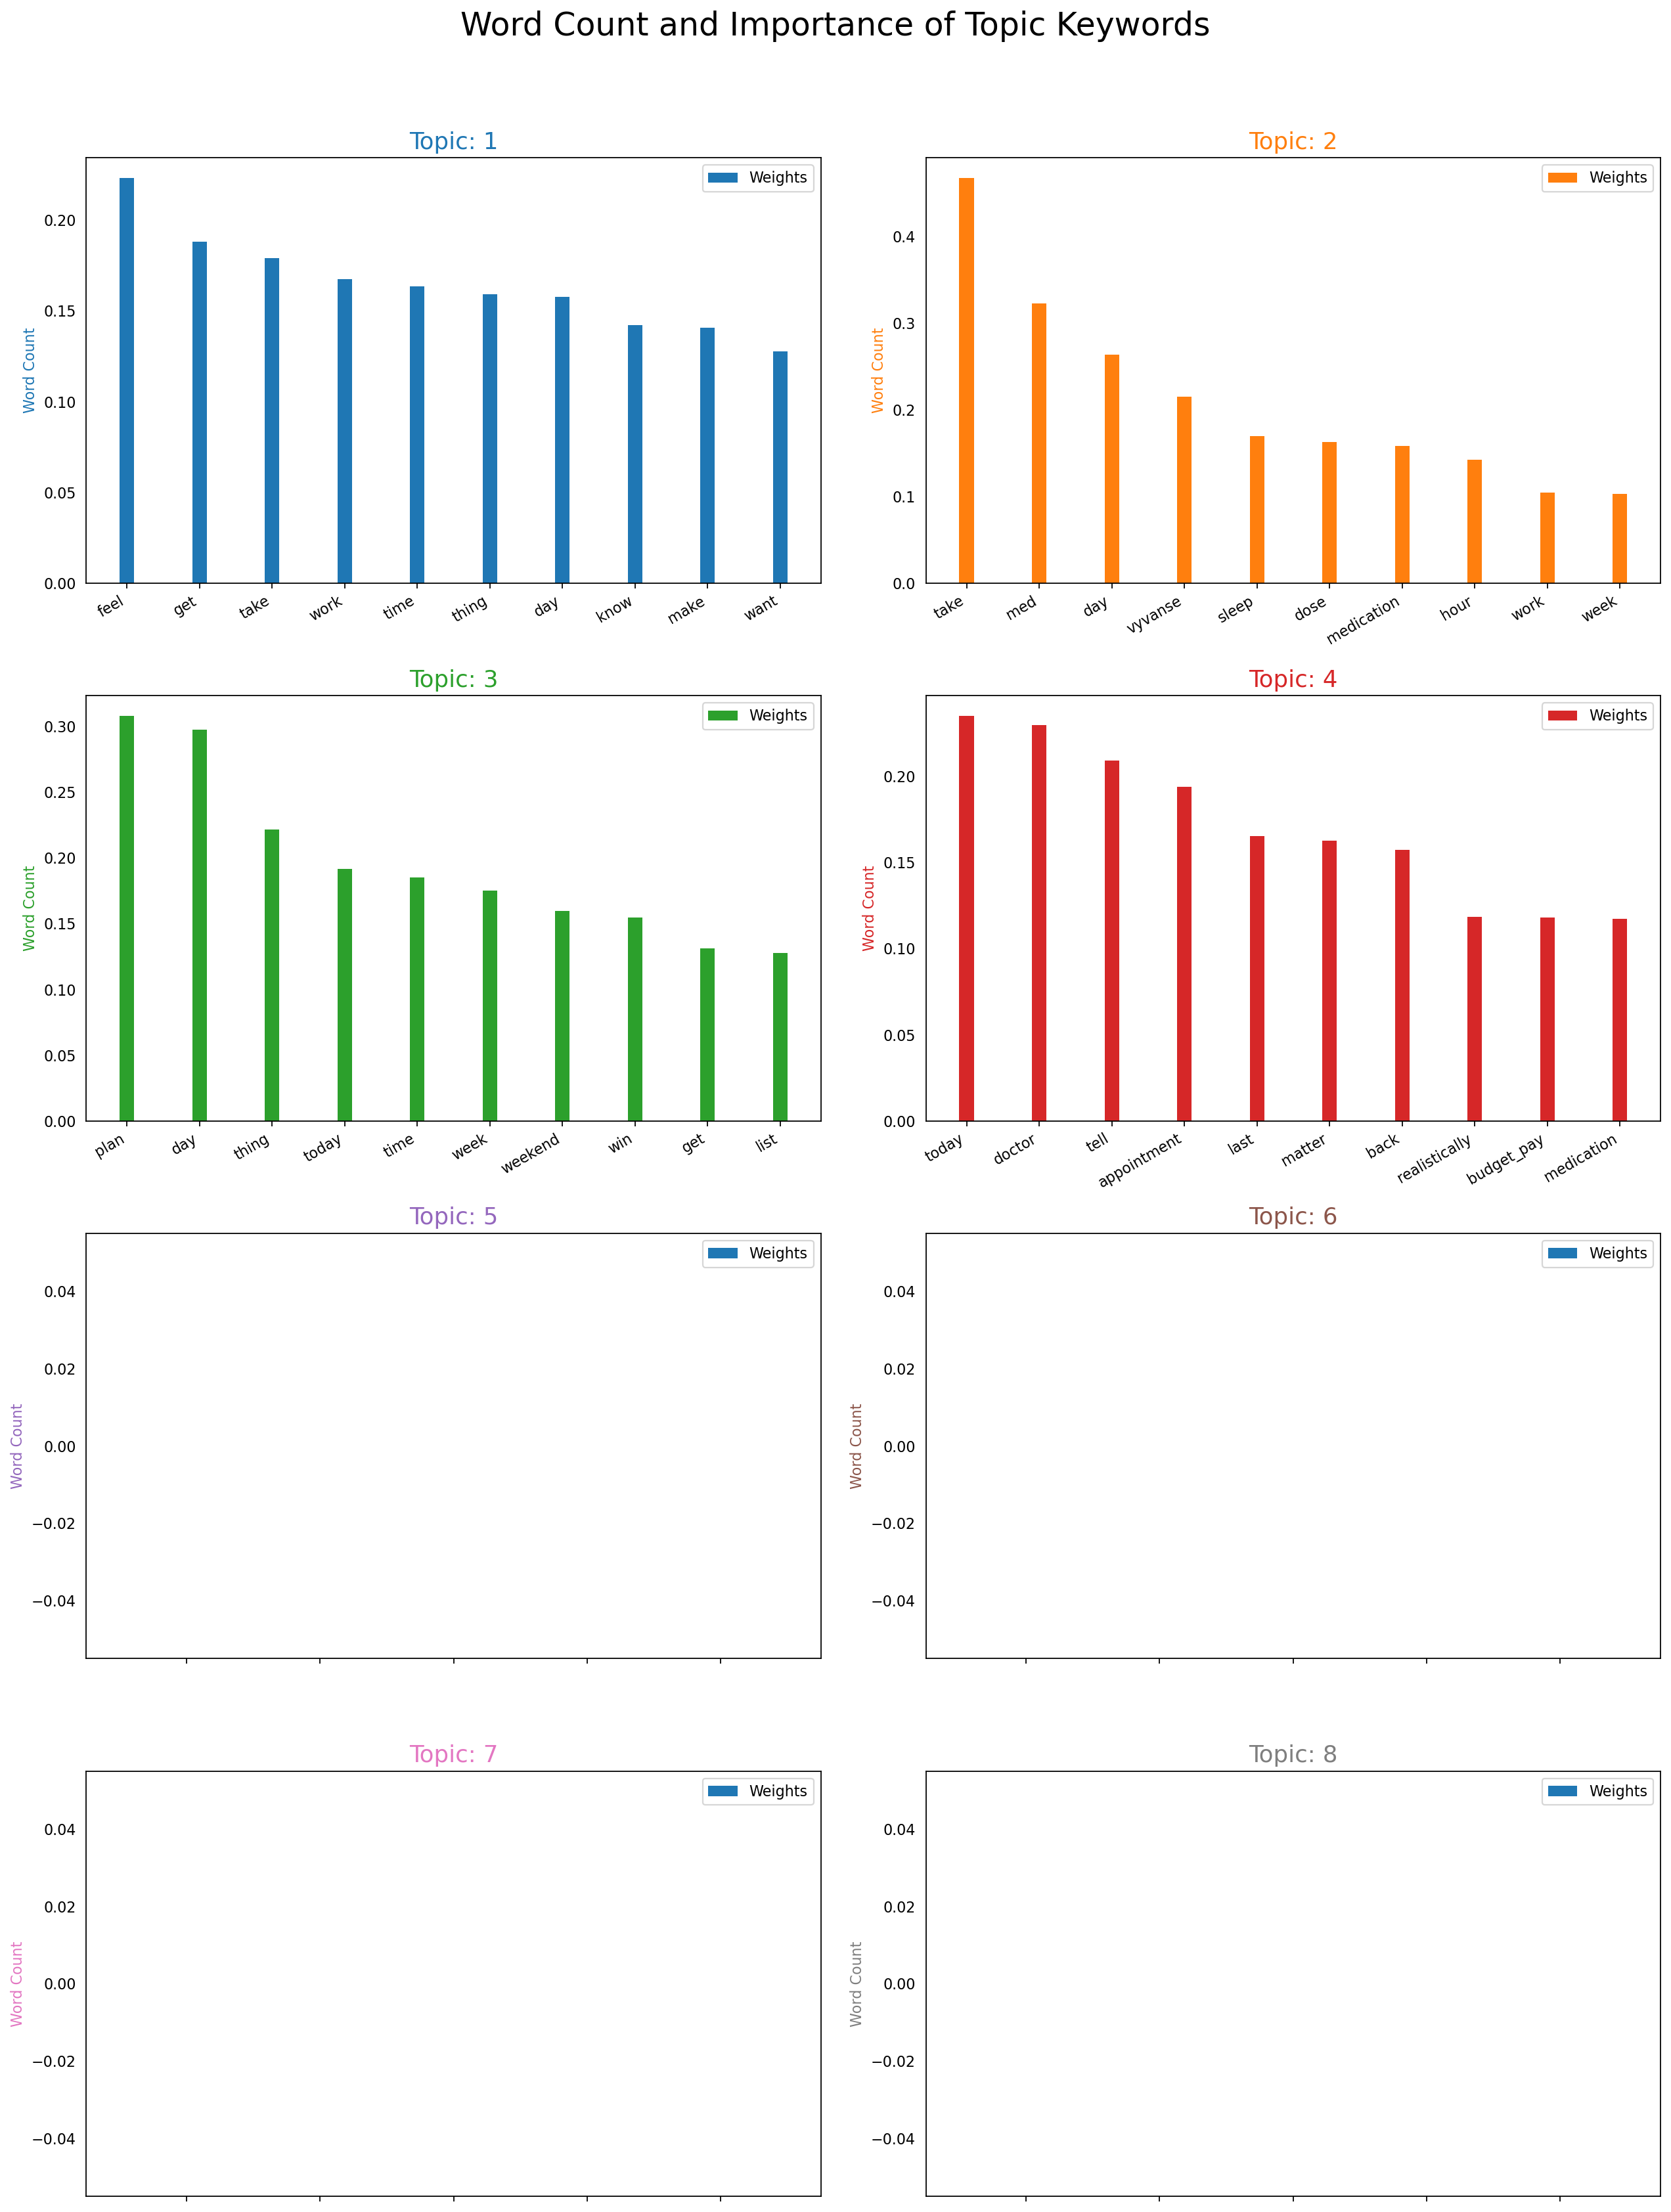

In [37]:
from collections import Counter
import seaborn as sns
import matplotlib.colors as mcolors
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(4, 2, figsize=(16,20), sharey=False, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    #ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i+1), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
#plt.show()
plt.savefig("D:\\2020-2\\소프트웨어융합캡스톤디자인\\new_jupyter\\data2\\LSA\\result\\adhd_lsa.png")

# 토픽별 갯수 세기

In [96]:
df_group = topic_df.groupby('Dominant_Topic').count()
df_group

,Unnamed: 0,Document_No,Topic_Perc_Contrib,Keywords,Text,content,topic_1,topic_2,topic_3,topic_4
Dominant_Topic,,,,,,,,,,
0.0,7750,7750,7750,7750,7750,7750,7750,7534,5707,2966
1.0,13071,13071,13071,13071,13071,13071,13071,12611,9658,6032
2.0,12593,12593,12593,12593,12593,12593,12593,11806,8628,4608
3.0,6744,6744,6744,6744,6744,6744,6744,6591,5269,3288


c:\users\samsung\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


Text(0, 0.5, 'num of document')

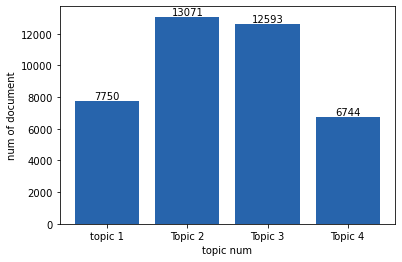

In [97]:
x = ["topic 1", "Topic 2", "Topic 3", "Topic 4"]
color = ['#2764AC'] #, '#77A0CF'
plt.bar(x, df_group['content'], color = color)

for x ,y in zip(df_group.index, df_group['content']):
    plt.text(x, y, y, ha = 'center', va = 'bottom')
    
ax = plt.subplot()
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels(["topic 1", "Topic 2", "Topic 3", "Topic 4"])

plt.xlabel("topic num")
plt.ylabel("num of document")

# 클러스터링

In [105]:
top_dist = topic_df[["topic_1", "topic_2", "topic_3", "topic_4"]]
top_dist = top_dist.fillna(0)

In [109]:
dominant_lsa_df = topic_df['Dominant_Topic']
dominant_lsa_df = dominant_lsa_df.astype('int')

In [111]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
import matplotlib.colors as mcolors

# Get topic weights
#topic_weights = []
#for i, row_list in enumerate(lda_model[corpus]):
#    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = top_dist
arr = top_dist.fillna(0).values

# Keep the well separated points (optional)
#arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num =dominant_lsa_df

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 4
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 40158 samples in 0.130s...
[t-SNE] Computed neighbors for 40158 samples in 1.496s...
[t-SNE] Computed conditional probabilities for sample 1000 / 40158
[t-SNE] Computed conditional probabilities for sample 2000 / 40158
[t-SNE] Computed conditional probabilities for sample 3000 / 40158
[t-SNE] Computed conditional probabilities for sample 4000 / 40158
[t-SNE] Computed conditional probabilities for sample 5000 / 40158
[t-SNE] Computed conditional probabilities for sample 6000 / 40158
[t-SNE] Computed conditional probabilities for sample 7000 / 40158
[t-SNE] Computed conditional probabilities for sample 8000 / 40158
[t-SNE] Computed conditional probabilities for sample 9000 / 40158
[t-SNE] Computed conditional probabilities for sample 10000 / 40158
[t-SNE] Computed conditional probabilities for sample 11000 / 40158
[t-SNE] Computed conditional probabilities for sample 12000 / 40158
[t-SNE] Computed conditional probabilities for sam

Loading BokehJS ...